<a href="https://colab.research.google.com/github/Mainakdeb/e_summit/blob/main/predict_personality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demostrates how our script works. Check out the main code here - https://github.com/Mainakdeb/*e_summit*


## Download models
We have uploaded trained algorithms into the github repo of our project, the following cell downloads the contents of the repository.

In [1]:
!git clone https://github.com/Mainakdeb/e_summit.git

Cloning into 'e_summit'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 136 (delta 72), reused 87 (delta 34), pack-reused 0
Receiving objects: 100% (136/136), 8.64 MiB | 11.94 MiB/s, done.
Resolving deltas: 100% (72/72), done.


## Install socialreaper version 0.3.0
Most of the dependencies needed are already available in colab, when running the script locally, make sure to run 
```
pip install -r requirements.txt
```

In [2]:
!pip3 install socialreaper==0.3.0

In [3]:
import optparse
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

from socialreaper import Twitter
from socialreaper.tools import to_csv

## Load the classifiers:

In [ ]:
cEXT = pickle.load( open( "/content/e_summit/models/cEXT.p", "rb"))
cNEU = pickle.load( open( "/content/e_summit/models/cNEU.p", "rb"))
cAGR = pickle.load( open( "/content/e_summit/models/cAGR.p", "rb"))
cCON = pickle.load( open( "/content/e_summit/models/cCON.p", "rb"))
cOPN = pickle.load( open( "/content/e_summit/models/cOPN.p", "rb"))
vectorizer_31 = pickle.load( open( "/content/e_summit/models/vectorizer_31.p", "rb"))
vectorizer_30 = pickle.load( open( "/content/e_summit/models/vectorizer_30.p", "rb"))

## Define get_profile( ):
the get_profile( ) function takes keywords/names as input and returns corresponding social media id's as a dictionary.

In [27]:
from googlesearch import search
import re

def get_profile(keyword):
  print("getting profiles from google..")
  results = list(search(keyword, num=10))
  profiles = {
      'twitter': '',
    #   'facebook': '',
    #   'linkedin':''
  }
  for r in results:
    if r.find('twitter') != -1 and profiles['twitter'] == '':
      r = re.search(r'https://twitter.com/([^/?]+)', r).group(1)
      profiles['twitter'] = r
    # if r.find('facebook') != -1 and profiles['facebook'] == '':
    #   r = re.search(r'https://www.facebook.com/([^/?]+)', r).group(1)
    #   profiles['facebook'] = r
    # if r.find('linkedin') != -1 and profiles['linkedin'] == '':
    #   r = re.search(r'https://in.linkedin.com/in/([^/?]+)', r).group(1)
    #   profiles['linkedin'] = r
  return profiles

## Define get_text_from_tweets( ) :
this function below takes the twitter username (string) as input, then gets rid of special characters using regex, and returns tweets corresponding to that user in form of a string. 

In the main script, we have saved the scraped tweets as information.txt to adhere with the problem statement.

In [28]:
twt = Twitter(app_key="PDz1fZLoCEHcOx035TtLsrcWS", 
              app_secret="Ok1aJBP4nM6g87F3hFiPFY0R0a7qnUNsdIoKZteaAuzYF2yTuF", 
              oauth_token="1292034807057149952-3Mlqa59ZAoqRdACgnW6z4goXUy3vUs", 
              oauth_token_secret="ZZlu7jF3mymeapDxwj19MkqCYF3osQjp48xYEuIL4wRM1")
    
def get_text_from_tweets(user_name):
    print("processing text from tweets..")
    tweets = twt.user(user_name, 
                    count=1000, 
                    exclude_replies=False, 
                    include_retweets=True)
        
    to_csv(list(tweets), filename=user_name+'_tweets.csv')

    tweets_df = pd.read_csv(user_name+"_tweets.csv")
    just_tweets=tweets_df[["text"]]
    ##remove urls 
    no_urls = just_tweets['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    #just_text_from_tweets.head(50)
    no_urls=no_urls.to_frame()

    # convert rows to a string
    tweets_string = ""
    for idx,row in no_urls.iterrows():
        tweets_string += (row['text'] + '. ')

    clean_text = re.sub("[^A-Za-z0-9. ]"," ",tweets_string)
    clean_text = clean_text.strip()
    return(clean_text)


## Define predict_personality( )
This function accepts a string as input and returns an array of floats, each corresponding to one of 5 personality traits.

In [29]:
def predict_personality(text):
    print("predicting traits..")
    sentences = re.split("(?<=[.!?]) +", text)
    text_vector_31 = vectorizer_31.transform(sentences)
    text_vector_30 = vectorizer_30.transform(sentences)
    EXT = cEXT.predict(text_vector_31)
    NEU = cNEU.predict(text_vector_30)
    AGR = cAGR.predict(text_vector_31)
    CON = cCON.predict(text_vector_31)
    OPN = cOPN.predict(text_vector_31)
    return [np.mean(EXT), np.mean(NEU), np.mean(AGR), np.mean(CON), np.mean(OPN)]

## Define display_results( ):
This function plots a bar chart, representing each of the 5 OCEAN tendencies of the user.

In [34]:
def display_results(predictions, user_name):
    #print("predicted personality:", predictions)
    df = pd.DataFrame(dict(r=predictions, theta=['EXT','NEU','AGR', 'CON', 'OPN']))
    attrs = list(df['r'])
    plt.rcParams["figure.figsize"] = (12, 6)
    plt.style.use('ggplot')
    plt.bar(['EXT','NEU','AGR', 'CON', 'OPN'],attrs, color ='green', alpha=0.5)
    plt.xlabel("Attribute")
    plt.ylabel("Tendency")
    plt.title(user_name+"'s Personality Report")
    plt.show()

##Moment of truth:
Feel free to replace Chetan Bhagat, try Narendra Modi, Ratan Tata.


In [35]:
user_name = get_profile("Narendra Modi")['twitter']
text = get_text_from_tweets(user_name)

getting profiles from google..
processing text from tweets..


predicting traits..


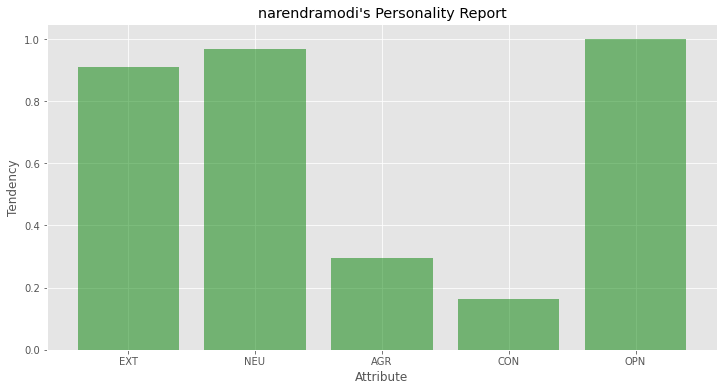

In [36]:
predictions = predict_personality(text)
display_results(predictions=predictions, user_name=user_name)

Do check out the main script - https://github.com/Mainakdeb/e_summit